In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../assets/modules/"))
from shapes import AISC_WSection
from materials import BilinearA992Steel
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
# Define steel material properties
A992 = BilinearA992Steel()

# Define beam and column shapes
W12X65 = AISC_WSection("W12X65") # Columns
W18X40 = AISC_WSection("W18X40") # Beams


In [3]:
import openseespy.opensees as ops
import vfo.vfo as vfo


ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)


nSEG = 4
colLength = 24 * 12.0  # inch, Height of the columns
L_beam1 = 30 * 12.0  # inch, Length of the beam in span 1
L_beam2 = 10 * 12.0  # inch, Length of the beam in span 2

base_nodeTags = [10, 20, 30]
base_XCoords = [0, L_beam1, L_beam1 + L_beam2]
nodeTags= deepcopy(base_nodeTags) # keep track of all node tags
bm_nodeTags = [] # Store beam node tags


# Define nodes
for base_nodeTag, base_XCoord in zip(base_nodeTags, base_XCoords):
    ops.node(base_nodeTag, base_XCoord, 0)
    ops.fix(base_nodeTag, 1, 1, 0) # pinned base nodes
    
    for i in range(1, nSEG + 1):
        new_nodeTag = base_nodeTag + i
        ops.node(new_nodeTag, base_XCoord, i * colLength/nSEG)
        nodeTags.append(new_nodeTag)
    bm_nodeTags.append(new_nodeTag)
    
# ops.equalDOF(bm_nodeTags[0], *bm_nodeTags[1:], 1)


# Define coordinate transformation (Options: Linear, PDelta, Corotational)
coordTransf = "Linear"
transfTag = 1
ops.geomTransf(coordTransf, transfTag)


# Define sections
col_secTag, bm_secTag = 1, 2
ops.section('Elastic', col_secTag, A992.E/1e3, W12X65.A, W12X65.Ix, A992.G/1e3, W12X65.alphaY)
ops.section('Elastic', bm_secTag, A992.E/1e3, W18X40.A, W18X40.Ix, A992.G/1e3, W18X40.alphaY)


# Define elements
col_eleTags = [] # keep track of all column element tags

# Define column elements
for base_nodeTag in base_nodeTags:
    for i in range(nSEG):
        eleTag = base_nodeTag + i
        col_eleTags.append(eleTag) 
        eleNodes = [base_nodeTag + i, base_nodeTag + (i + 1)]
        ops.element('elasticBeamColumn', eleTag, *eleNodes, col_secTag, transfTag)
        
# Define beam elements
bm_eleTags = [101, 102]
ops.element('elasticBeamColumn', bm_eleTags[0], base_nodeTags[0] + nSEG, base_nodeTags[1] + nSEG, bm_secTag, transfTag)
ops.element('elasticBeamColumn', bm_eleTags[1], base_nodeTags[1] + nSEG, base_nodeTags[2] + nSEG, bm_secTag, transfTag, '-release', 3)
# moment release: 0=no release (default), 1=release at I, 2=release at J, 3=release at I and J



# Define time series
timeSeriesTag = 1
ops.timeSeries("Linear", timeSeriesTag)


# Define load pattern
patternTag = 1
ops.pattern("Plain", patternTag, timeSeriesTag)


# Define loads
ops.load(base_nodeTags[0] + nSEG, 0.576, -36.0, 0.0)
ops.load(base_nodeTags[1] + nSEG, 0.0, -36.0, 0.0)
ops.load(base_nodeTags[2] + nSEG, 0.0, -144.0, 0.0)
ops.eleLoad('-ele', bm_eleTags[0], '-type', '-beamUniform', -2.40 / 12, 0.0) # kip/in, uniform load in y-direction


# Define analysis parameters
ops.system('BandGen')
ops.numberer('Plain') # Plain, RCM, AMD
ops.constraints("Plain") # Plain, Transformation
ops.algorithm('Newton') # Linear, Newton, KrylovNewton, KrylovNewtonWithInertia, ...
ops.test('NormDispIncr', 1.0e-6, 10)


numIncr = 10
ops.integrator('LoadControl', 1.0/numIncr) # LoadControl, DisplacementControl, FixedNumIter


ops.analysis('Static') # Static, Transient, VariableTransient, PFEM


# ops.database('File', 'aisc_example_c1a')


ops.recorder('Node', '-file', 'node_disp.out', '-time', '-node', *bm_nodeTags, '-dof', 1, 2, 3, 'disp')
ops.recorder('Node', '-file', 'reaction.out', '-time', '-node', *base_nodeTags, '-dof', 1, 2, 3, 'reaction')
ops.recorder('Element', '-file', 'element.out', '-time', '-ele', *bm_eleTags, 'force')


vfo.createODB(model='aisc_example_c1a', loadcase='static')


flag = ops.analyze(numIncr)
if  flag != 0:
    print("Analysis failed!")
else:
    print("Analysis completed successfully.")

Analysis completed successfully.


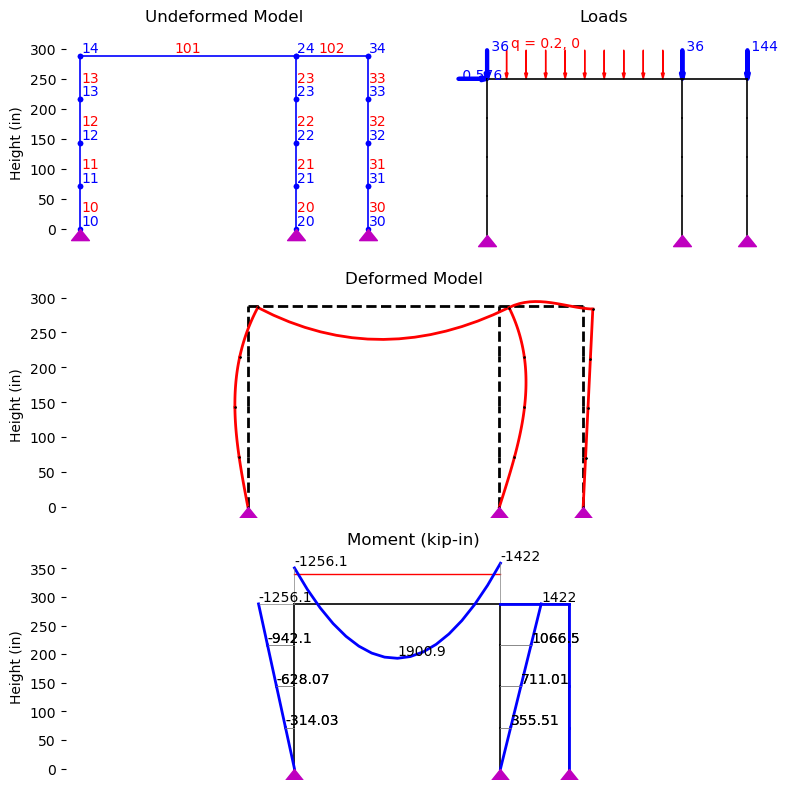

In [4]:
import matplotlib.gridspec as gridspec
import opsvis as opsv

fig= plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0])

ax_model = fig.add_subplot(gs0[0])
ax_load = fig.add_subplot(gs0[1])
ax_defo = fig.add_subplot(gs[1])
ax_moment = fig.add_subplot(gs[2])

def remove_borders(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)
        
# Plot undeformed model
opsv.plot_model(
    ax=ax_model,
    offset_nd_label=True
)
ax_model.set_ylabel("Height (in)")
ax_model.set_xticks([])
ax_model.set_title("Undeformed Model")
remove_borders(ax_model)

# Plot loading
opsv.plot_load(ax=ax_load)
ax_load.set_xticks([])
ax_load.set_yticks([])
ax_load.set_title("Loads")
remove_borders(ax_load)

# Plot deformed model
def_sfac = opsv.plot_defo(
    ax=ax_defo, 
    fmt_undefo={'color': 'black', 'linestyle': '--', 'linewidth': 2}, 
    fmt_defo={'color': 'red', 'linewidth': 2}
)
ax_defo.set_xticks([])
ax_defo.set_ylabel("Height (in)")
ax_defo.set_title("Deformed Model")
remove_borders(ax_defo)

# Plot moment diagram
m_sfac = 0.05
opsv.section_force_diagram_2d(
    sf_type='M', 
    sfac=m_sfac,
    fmt_secforce1={'color': 'blue', 'linewidth': 2},
    fmt_secforce2={'color': 'grey', 'linewidth': 0.5},
    ref_vert_lines=False,
    ax=ax_moment
)
ax_moment.set_xticks([])
ax_moment.set_ylabel("Height (in)")
ax_moment.set_title("Moment (kip-in)")
remove_borders(ax_moment)

fig.tight_layout()
plt.show()


In [5]:
# ops.printModel('-node', *bm_nodeTags)
# ops.printModel('-node', *base_nodeTags)
# ops.printModel('-ele', *bm_eleTags)

In [6]:
print("Floor lateral displacements:")
for nodeTag in bm_nodeTags:
    print(f"  Node {nodeTag}: {ops.nodeDisp(nodeTag, 1):.3f} in")
    
print("\nBase reactions:")
for nodeTag in base_nodeTags:
    print(f"  Node {nodeTag}: Rh={ops.nodeReaction(nodeTag, 1):.3f} kip")
    
print("\nBeam end moments:")
for eleTag in bm_eleTags:
    print(f"  Element {eleTag}: Mi={ops.eleForce(eleTag, 3)/12:.1f}, Mj={ops.eleForce(eleTag, 6)/12:.1f} kip-ft")

Floor lateral displacements:
  Node 14: 0.232 in
  Node 24: 0.227 in
  Node 34: 0.227 in

Base reactions:
  Node 10: Rh=4.362 kip
  Node 20: Rh=-4.938 kip
  Node 30: Rh=0.000 kip

Beam end moments:
  Element 101: Mi=104.7, Mj=-118.5 kip-ft
  Element 102: Mi=0.0, Mj=0.0 kip-ft
